#### Exile on Online Opposition

Examine the effect of exile on percentage of tweets' harsh criticism of Venezuela government.

ESBERG, J., & SIEGEL, A. (2023). How Exile Shapes Online Opposition: Evidence from Venezuela. American Political Science Review, 117(4), 1361-1378.

In [17]:
# load gpytoch and other packages
import torch
import numpy as np
import pandas as pd
import gpytorch
from scipy.stats import norm
from matplotlib import pyplot as plt
from gpytorch.means import ZeroMean, LinearMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel
from datetime import datetime

torch.set_default_dtype(torch.float64)
torch.manual_seed(12345)

we first implement GPR for right panel of figure 4.

In [18]:
# read data
data = pd.read_csv("./data/exile.csv")
data = data[["perc_harsh_criticism", "lead_lags","month","num_tweets", "date_of_exile", "actor.id"]]
data = data[~data.lead_lags.isna()]

def diff_month(d1, d2):
    d1 = datetime.strptime(d1,"%Y-%m-%d")
    d2 = datetime.strptime(d2,"%Y-%m-%d")
    return (d1.year - d2.year) * 12 + d1.month - d2.month

# xs: unit id, month, log_num_tweets, dummies for lead_lags
xs = data.month.apply(lambda x: diff_month(x,"2013-01-01"))
xs = torch.tensor(np.hstack((data["actor.id"].astype('category').cat.codes.values.reshape((-1,1)),\
                    xs.values.reshape((-1,1)),
                    np.log(data.num_tweets.values+1).reshape((-1,1)), \
                    pd.get_dummies(data['lead_lags']).values))).double()
ys = torch.tensor(data.perc_harsh_criticism.values).double()

we build a Gaussian process regression model with a linear mean function and an automatic relevance determination RBF kernel:
$$
f(t,D) \sim\mathcal{GP}(\beta x,K)
$$

In [19]:
from gpytorch.means import Mean
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class ConstantVectorMean(Mean):
    def __init__(self, n, prior=None, batch_shape=torch.Size(), **kwargs):
        super().__init__()
        self.batch_shape = batch_shape
        self.register_parameter(name="constantvector",\
                 parameter=torch.nn.Parameter(torch.zeros(*batch_shape, n)))
    
    def forward(self, input):
        return self.constantvector[input.long()]

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # linear mean
        self.mean_module = LinearMean(input_size=(inducing_points.size(1)-2), bias=False)
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=(inducing_points.size(1)-2)))
        self.t_covar_module = ScaleKernel(RBFKernel(active_dims=[0])*RBFKernel(active_dims=[1]))

    def forward(self, x):
        mean_x = self.mean_module(x[:,2:])
        covar_x = self.covar_module(x[:,2:]) + self.t_covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [20]:
from torch.utils.data import TensorDataset, DataLoader

inducing_points = xs[np.random.choice(xs.size(0),1000,replace=False),:]
model = GPModel(inducing_points=inducing_points).double()
likelihood = GaussianLikelihood().double()

train_dataset = TensorDataset(xs, ys)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# initialize model parameters
model.t_covar_module.base_kernel.kernels[0].raw_lengthscale.require_grad = False
model.t_covar_module.base_kernel.kernels[0].lengthscale = 0.1
model.t_covar_module.raw_outputscale.require_grad = False
model.t_covar_module.outputscale = 1.
model.covar_module.raw_outputscale.requires_grad = False
model.covar_module.outputscale = 1.
likelihood.noise = 1.

# train model
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': list(set(model.parameters()) - \
                {model.t_covar_module.base_kernel.kernels[0].raw_lengthscale,\
                model.t_covar_module.raw_outputscale,\
                model.covar_module.raw_outputscale})},
    {'params': likelihood.parameters()},
], lr=0.05)

# "Loss" for GPs
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=ys.size(0))

num_epochs = 20
for i in range(num_epochs):
    for j, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        if j % 50:
            print('Epoch %d Iter %d - Loss: %.3f' % (i + 1, j+1, loss.item()))


Epoch 1 Iter 2 - Loss: 189.349
Epoch 1 Iter 3 - Loss: 171.356
Epoch 1 Iter 4 - Loss: 180.147
Epoch 1 Iter 5 - Loss: 153.898
Epoch 1 Iter 6 - Loss: 123.403
Epoch 1 Iter 7 - Loss: 135.199
Epoch 1 Iter 8 - Loss: 133.921
Epoch 1 Iter 9 - Loss: 108.711
Epoch 1 Iter 10 - Loss: 117.488
Epoch 1 Iter 11 - Loss: 99.816
Epoch 1 Iter 12 - Loss: 106.587
Epoch 1 Iter 13 - Loss: 98.036
Epoch 1 Iter 14 - Loss: 83.112
Epoch 1 Iter 15 - Loss: 88.746
Epoch 1 Iter 16 - Loss: 69.555
Epoch 1 Iter 17 - Loss: 86.583
Epoch 1 Iter 18 - Loss: 76.788
Epoch 1 Iter 19 - Loss: 74.607
Epoch 1 Iter 20 - Loss: 68.791
Epoch 1 Iter 21 - Loss: 79.606
Epoch 1 Iter 22 - Loss: 73.140
Epoch 1 Iter 23 - Loss: 93.630
Epoch 2 Iter 2 - Loss: 61.623
Epoch 2 Iter 3 - Loss: 67.125
Epoch 2 Iter 4 - Loss: 80.656
Epoch 2 Iter 5 - Loss: 62.133
Epoch 2 Iter 6 - Loss: 59.033
Epoch 2 Iter 7 - Loss: 68.869
Epoch 2 Iter 8 - Loss: 56.350
Epoch 2 Iter 9 - Loss: 58.138
Epoch 2 Iter 10 - Loss: 60.868
Epoch 2 Iter 11 - Loss: 59.588
Epoch 2 Iter 1

In [21]:
# set model and likelihood to evaluation mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = model(xs)
    mu_f = out.mean.numpy()
    lower, upper = out.confidence_region()

# store results
results = pd.DataFrame({"gpr_mean":mu_f})
results['true_y'] = ys
results['gpr_lwr'] = lower
results['gpr_upr'] = upper
results['month'] = xs[:,1].numpy().astype(int)
results['unit'] = xs[:,0].numpy().astype(int)
results.to_csv("./results/exile_fitted_gpr.csv",index=False) #save to file

In [22]:
model.eval()
likelihood.eval()

# number of empirically sample 
n_samples = 100
x_grad = np.zeros((xs.size(0),xs.size(1)))
sampled_dydtest_x = np.zeros((n_samples, xs.size(0),xs.size(1)))

# we proceed in small batches of size 100 for speed up
for i in range(xs.size(0)//100):
    with gpytorch.settings.fast_pred_var():
        test_x = xs[(i*100):(i*100+100)].clone().detach().requires_grad_(True)
        observed_pred = model(test_x)
        dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
        x_grad[(i*100):(i*100+100)] = dydtest_x

        sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
        sampled_dydtest_x[:,(i*100):(i*100+100),:] = torch.stack([torch.autograd.grad(pred.sum(), \
                                    test_x, retain_graph=True)[0] for pred in sampled_pred])
        
# last 100 rows
with gpytorch.settings.fast_pred_var():
    test_x = xs[(100*i+100):].clone().detach().requires_grad_(True)
    observed_pred = model(test_x)
    dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
    x_grad[(100*i+100):] = dydtest_x

    sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
    sampled_dydtest_x[:,(100*i+100):,:] = torch.stack([torch.autograd.grad(pred.sum(),\
                                     test_x, retain_graph=True)[0] for pred in sampled_pred])
    

In [23]:
est_std = np.sqrt(sampled_dydtest_x.mean(1).var(0) + \
                  sampled_dydtest_x.var(1).mean(0)).round(decimals=5)
covariate_names = ["time","log_num_tweets"]
for tmp in pd.get_dummies(data['lead_lags']).columns.tolist():
    covariate_names.append("beta "+tmp)
results = pd.DataFrame({"x": covariate_names, \
                        'est_mean': x_grad.mean(axis=0)[1:],
                        'est_std': est_std[1:]})
results["t"] = results['est_mean'].values/results['est_std'].values
results["pvalue"] = 1 - norm.cdf(np.abs(results["t"].values))
print(results)

                    x   est_mean   est_std         t    pvalue
0                time   0.021465   1.79999  0.011925  0.495243
1      log_num_tweets   0.297033   2.61566  0.113559  0.454794
2             beta -2   0.551435   2.58243  0.213533  0.415455
3             beta -3   1.874428   5.91589  0.316846  0.375680
4             beta -4   1.328554   5.20095  0.255444  0.399190
5             beta -5   1.461899   5.79166  0.252414  0.400360
6             beta -6   2.128063   3.79795  0.560319  0.287631
7              beta 0   3.488480   4.95499  0.704034  0.240706
8              beta 1   4.633176   4.63900  0.998745  0.158959
9             beta 10   6.279680   5.86278  1.071110  0.142060
10            beta 11   3.861292   2.48533  1.553633  0.060136
11             beta 2   3.535981   3.49856  1.010696  0.156081
12             beta 3   4.474892   3.31384  1.350364  0.088450
13             beta 4   3.196683   2.28952  1.396224  0.081324
14             beta 5   3.399454   2.67746  1.269656  0

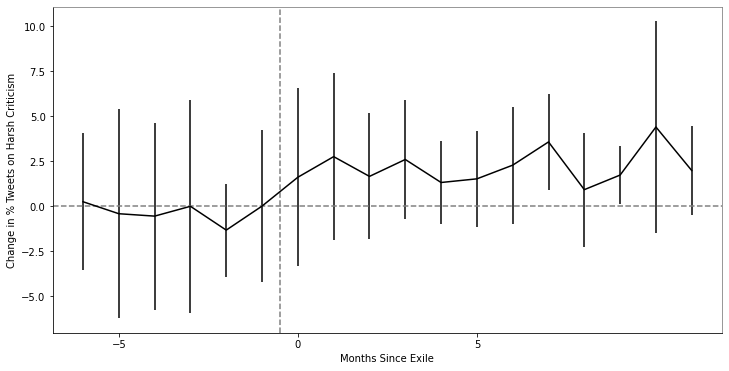

In [28]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))

plot_est_mean = []
plot_est_std = []
for i in range(-6,12):
    if i==-7:
        plot_est_mean.append(results[results.x==("beta pre")].est_mean.values[0])
        plot_est_std.append(results[results.x==("beta pre")].est_std.values[0])
    elif i==12:
        plot_est_mean.append(results[results.x==("beta post")].est_mean.values[0])
        plot_est_std.append(results[results.x==("beta post")].est_std.values[0])
    elif i==-1:
        plot_est_mean.append(results[results.x==("beta month_before")].est_mean.values[0])
        plot_est_std.append(results[results.x==("beta month_before")].est_std.values[0])
    else:
        plot_est_mean.append(results[results.x==("beta "+str(i))].est_mean.values[0])
        plot_est_std.append(results[results.x==("beta "+str(i))].est_std.values[0])
ax.errorbar([i  for i in range(-6,12)], np.array(plot_est_mean)-plot_est_mean[5], yerr=plot_est_std, fmt="k", ecolor="k")
ax.axvline(x=-0.5, ls="--", color="gray")
ax.axhline(y=0, ls="--", color="gray")
ax.set_xlabel("Months Since Exile")
ax.set_ylabel("Change in % Tweets on Harsh Criticism")
ax.set_xticks(range(-5,10,5))
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')

next we estimate effect of exile on percentage of harsh criticism for left panel of figure 4.

In [52]:
# read data
data = pd.read_csv("./data/exile.csv")
data = data[["perc_harsh_criticism", "exile", "month","num_tweets", "date_of_exile", "actor.id"]]

def diff_month(d1, d2):
    d1 = datetime.strptime(d1,"%Y-%m-%d")
    d2 = datetime.strptime(d2,"%Y-%m-%d")
    return (d1.year - d2.year) * 12 + d1.month - d2.month

# xs: unit id, month, log_num_tweets, exile
xs = data.month.apply(lambda x: diff_month(x,"2013-01-01"))
xs = torch.tensor(np.hstack((data["actor.id"].astype('category').cat.codes.values.reshape((-1,1)),\
                    xs.values.reshape((-1,1)),
                    np.log(data.num_tweets.values+1).reshape((-1,1)), \
                    data['exile'].values.reshape((-1,1))=="yes")))
ys = torch.tensor(data.perc_harsh_criticism.values).double()

In [53]:
from gpytorch.means import Mean
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=False)
        super(GPModel, self).__init__(variational_strategy)
        # linear mean
        self.mean_module = LinearMean(input_size=(inducing_points.size(1)-2), bias=False)
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=(inducing_points.size(1)-2)))
        self.t_covar_module = ScaleKernel(RBFKernel(active_dims=[0])*RBFKernel(active_dims=[1,2]))

    def forward(self, x):
        mean_x = self.mean_module(x[:,2:])
        covar_x =  self.t_covar_module(x) # self.covar_module(x[:,2:]) +
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [54]:
inducing_points = xs[np.random.choice(xs.size(0),1000,replace=False),:]
model = GPModel(inducing_points=inducing_points).double()
likelihood = GaussianLikelihood().double()

train_dataset = TensorDataset(xs, ys)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# initialize model parameters
model.t_covar_module.base_kernel.kernels[0].raw_lengthscale.require_grad = False
model.t_covar_module.base_kernel.kernels[0].lengthscale = 0.1
model.t_covar_module.outputscale = 1.
likelihood.noise = 1.

# train model
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': list(set(model.parameters()) - \
                {model.t_covar_module.base_kernel.kernels[0].raw_lengthscale,\
                model.t_covar_module.raw_outputscale})},
    {'params': likelihood.parameters()},
], lr=0.05)

# "Loss" for GPs
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=ys.size(0))

num_epochs = 10
for i in range(num_epochs):
    for j, (x_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        if j % 50:
            print('Epoch %d Iter %d - Loss: %.3f' % (i + 1, j+1, loss.item()))


Epoch 1 Iter 2 - Loss: 521.803
Epoch 1 Iter 3 - Loss: 477.685
Epoch 1 Iter 4 - Loss: 457.833
Epoch 1 Iter 5 - Loss: 449.835
Epoch 1 Iter 6 - Loss: 409.039
Epoch 1 Iter 7 - Loss: 405.476
Epoch 1 Iter 8 - Loss: 377.295
Epoch 1 Iter 9 - Loss: 374.548
Epoch 1 Iter 10 - Loss: 344.834
Epoch 1 Iter 11 - Loss: 339.551
Epoch 1 Iter 12 - Loss: 304.868
Epoch 1 Iter 13 - Loss: 301.306
Epoch 1 Iter 14 - Loss: 308.258
Epoch 1 Iter 15 - Loss: 281.179
Epoch 1 Iter 16 - Loss: 287.761
Epoch 1 Iter 17 - Loss: 273.210
Epoch 1 Iter 18 - Loss: 272.289
Epoch 1 Iter 19 - Loss: 261.264
Epoch 1 Iter 20 - Loss: 258.386
Epoch 1 Iter 21 - Loss: 232.067
Epoch 1 Iter 22 - Loss: 230.230
Epoch 1 Iter 23 - Loss: 190.588
Epoch 2 Iter 2 - Loss: 195.023
Epoch 2 Iter 3 - Loss: 205.237
Epoch 2 Iter 4 - Loss: 210.496
Epoch 2 Iter 5 - Loss: 186.999
Epoch 2 Iter 6 - Loss: 181.785
Epoch 2 Iter 7 - Loss: 185.955
Epoch 2 Iter 8 - Loss: 185.339
Epoch 2 Iter 9 - Loss: 191.544
Epoch 2 Iter 10 - Loss: 164.100
Epoch 2 Iter 11 - Loss: 

In [55]:
# set model and likelihood to evaluation mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = model(xs)
    mu_f = out.mean.numpy()
    lower, upper = out.confidence_region()

# store results
results = pd.DataFrame({"gpr_mean":mu_f})
results['true_y'] = ys
results['gpr_lwr'] = lower
results['gpr_upr'] = upper
results['month'] = xs[:,1].numpy().astype(int)
results['unit'] = xs[:,0].numpy().astype(int)
results.to_csv("./results/exile_fitted_gpr.csv",index=False) #save to file

In [56]:
model.eval()
likelihood.eval()

# number of empirically sample 
n_samples = 100
x_grad = np.zeros((xs.size(0),xs.size(1)))
sampled_dydtest_x = np.zeros((n_samples, xs.size(0),xs.size(1)))

# we proceed in small batches of size 100 for speed up
for i in range(xs.size(0)//100):
    with gpytorch.settings.fast_pred_var():
        test_x = xs[(i*100):(i*100+100)].clone().detach().requires_grad_(True)
        observed_pred = model(test_x)
        dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
        x_grad[(i*100):(i*100+100)] = dydtest_x

        sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
        sampled_dydtest_x[:,(i*100):(i*100+100),:] = torch.stack([torch.autograd.grad(pred.sum(), \
                                    test_x, retain_graph=True)[0] for pred in sampled_pred])
        
# last 100 rows
with gpytorch.settings.fast_pred_var():
    test_x = xs[(100*i+100):].clone().detach().requires_grad_(True)
    observed_pred = model(test_x)
    dydtest_x = torch.autograd.grad(observed_pred.mean.sum(), test_x, retain_graph=True)[0]
    x_grad[(100*i+100):] = dydtest_x

    sampled_pred = observed_pred.rsample(torch.Size([n_samples]))
    sampled_dydtest_x[:,(100*i+100):,:] = torch.stack([torch.autograd.grad(pred.sum(),\
                                     test_x, retain_graph=True)[0] for pred in sampled_pred])
    

In [59]:
est_std = np.sqrt(sampled_dydtest_x.mean(1).var(0) + \
                  sampled_dydtest_x.var(1).mean(0)).round(decimals=5)
covariate_names = ["time","log_num_tweets"]
results = pd.DataFrame({"x": covariate_names, \
                        'est_mean': x_grad.mean(axis=0)[1:3],
                        'est_std': est_std[1:3]})
results["t"] = results['est_mean'].values/results['est_std'].values
results["pvalue"] = 1 - norm.cdf(np.abs(results["t"].values))
print(results)

                x  est_mean  est_std         t    pvalue
0            time  0.012651  2.30062  0.005499  0.497806
1  log_num_tweets  1.385515  2.89643  0.478353  0.316200


In [65]:
model.eval()
likelihood.eval()

# copy training tesnor to test tensors and set exile to 1 and 0
test_x1 = xs.clone().detach().requires_grad_(False)
test_x1[:,3] = 1
test_x0 = xs.clone().detach().requires_grad_(False)
test_x0[:,3] = 0

# in eval mode the forward() function returns posterioir
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out1 = likelihood(model(test_x1))
    out0 = likelihood(model(test_x0))

# compute ATE and its uncertainty
effect = out1.mean.numpy().mean() - out0.mean.numpy().mean()
effect_std = np.sqrt((out1.mean.numpy().mean()+out0.mean.numpy().mean())) / np.sqrt(xs.size()[0])
BIC = (1+1+2+1)*\
    torch.log(torch.tensor(xs.size()[0])) + 2*loss*xs.size(0)/1024
print("ATE: {:0.3f} +- {:0.3f}\n".format(effect, effect_std))
print("model evidence: {:0.3f} \n".format(-loss*xs.size(0)/1024))
print("BIC: {:0.3f} \n".format(BIC))

ATE: 5.286 +- 0.031

model evidence: -542.339 

BIC: 1134.822 

